/tmp/ipykernel_415140/2769537823.py:80: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



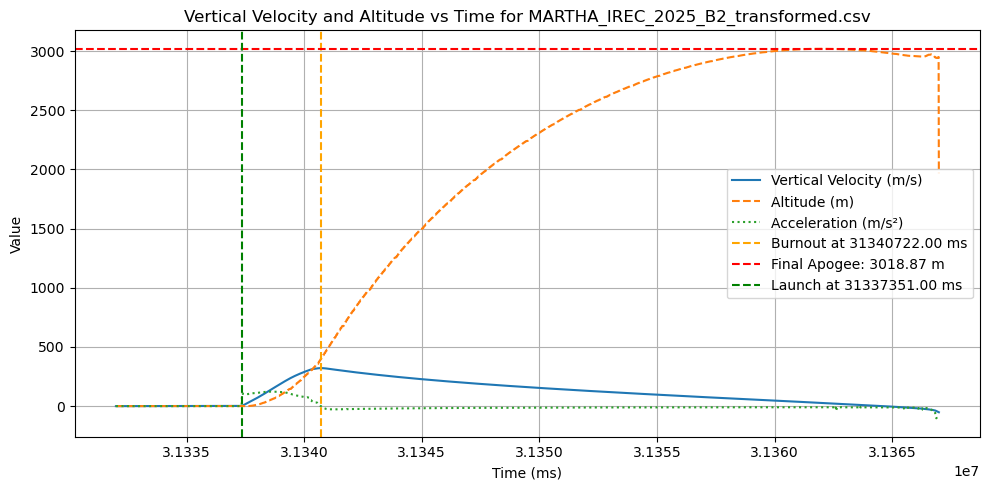

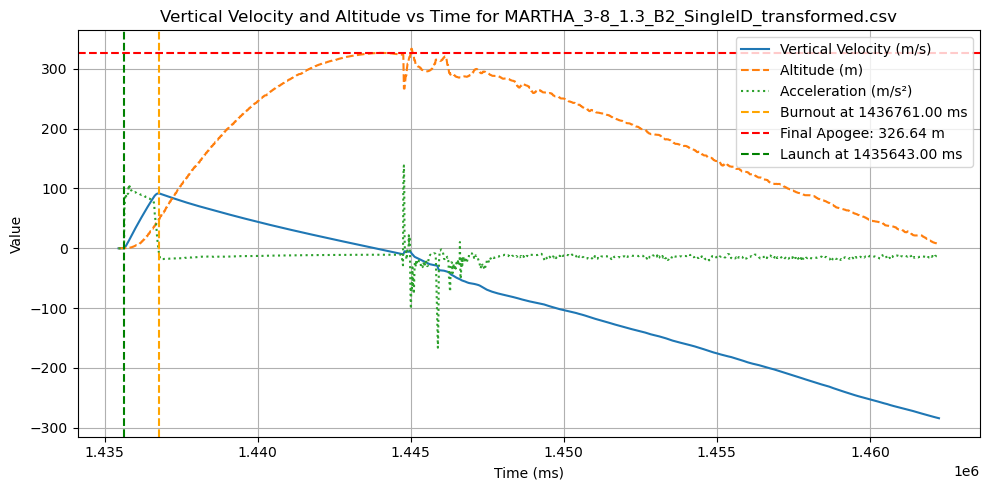

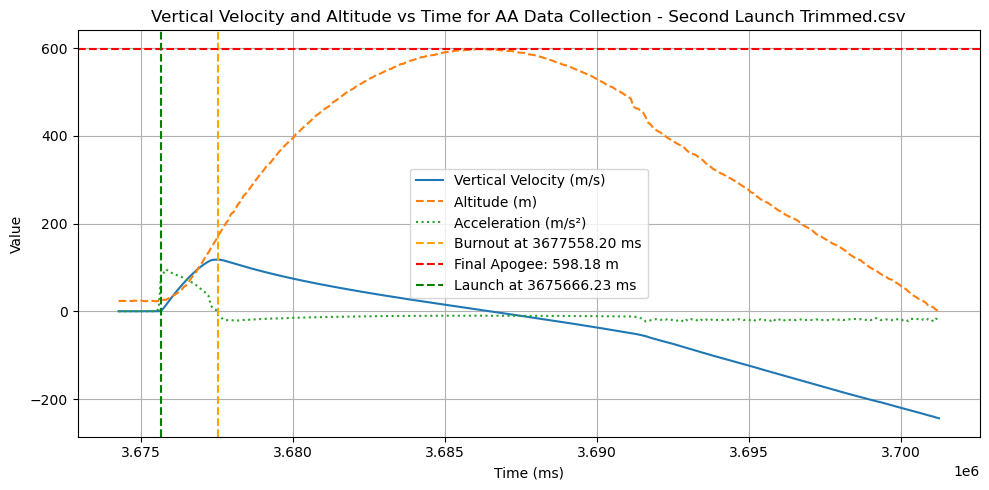

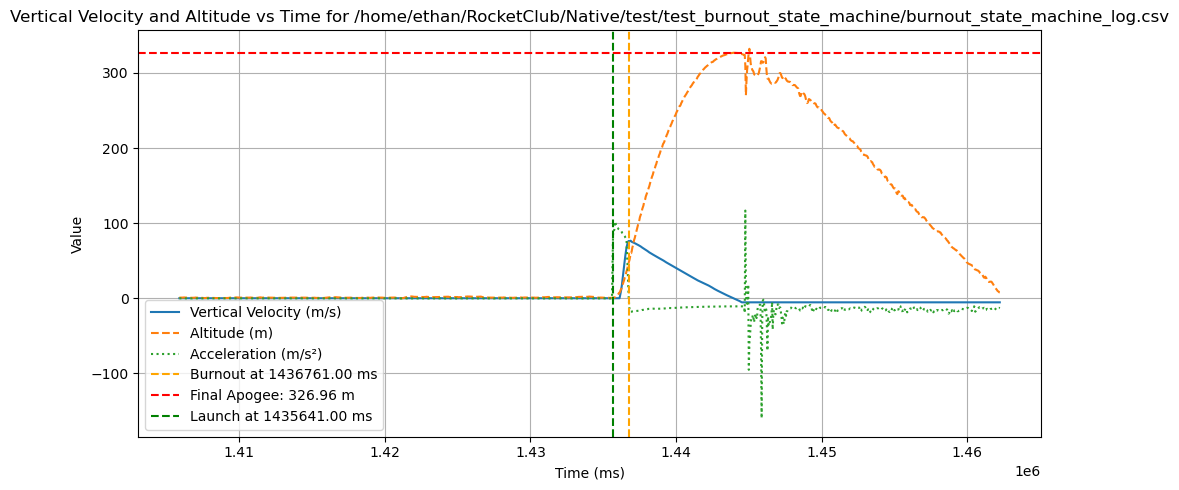

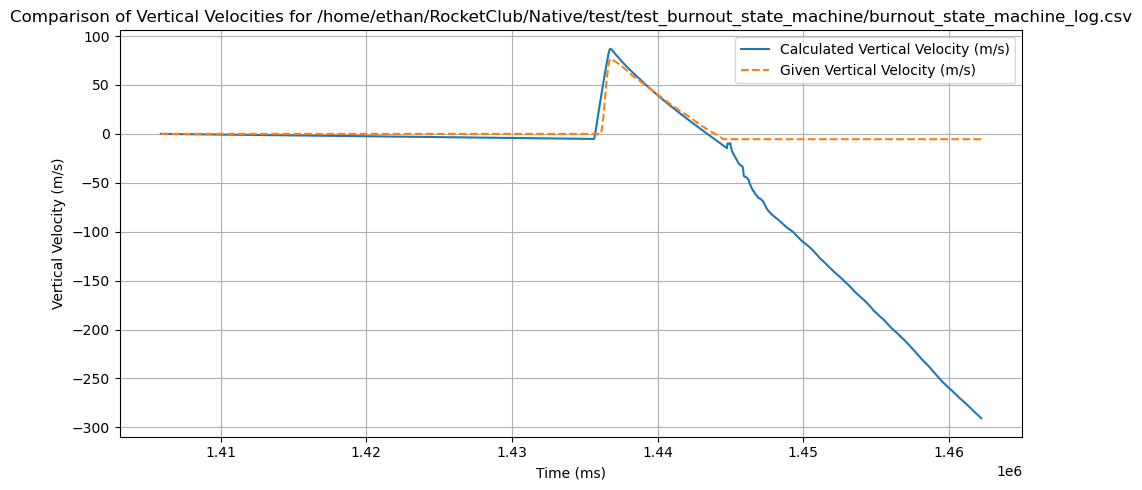

In [331]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

DATASETS = [
    # FILE PATH, ACCELERATION COLUMN, MULTIPLIER (1 for positive, -1 for negative i.e. mounted upside down)
    ("MARTHA_IREC_2025_B2_transformed.csv", 'accelz', 1),
    ("MARTHA_3-8_1.3_B2_SingleID_transformed.csv", 'accely', -1),
    ("AA Data Collection - Second Launch Trimmed.csv", 'accelx', 1),
    ("/home/ethan/RocketClub/Native/test/test_burnout_state_machine/burnout_state_machine_log.csv", 'accely', -1),
]

g = 9.81  # m/s², acceleration due to gravity

training_data = pd.DataFrame(columns=["time", "altitude", "vertical_velocity", "vertical_acceleration", "apogee", "flight_name"])

for dataset, accel_col, accel_multiplier in DATASETS:

    # Load CSV data
    df = pd.read_csv(dataset)  # replace with actual path

    # Find peak accleeration and immediatly trim 
    peak_acceleration = df[accel_col].max()
    peak_index = df[accel_col].idxmax()
    start_index = max(0, peak_index - 1000)  # 1 second before peak
    end_index = min(len(df), peak_index + 30000)  # 30 seconds after peak
    df = df.iloc[start_index:end_index].reset_index(drop=True)
    
    df['vertical_acceleration'] = df[accel_col] * accel_multiplier - g  # Adjust acceleration to be relative to gravity

    df['flight_name'] = "".join(dataset.split('.')[:-1])

    # Adjust altitude to start at 0
    if 'altitude' in df.columns:
        df['altitude'] = df['altitude'] - df['altitude'].min()

    # Convert time from milliseconds to seconds for integration
    df["time_sec"] = df["time"] / 1000.0

    
    # Assume initial vertical velocity is 0
    velocity = [0.0]

    # Numerically integrate acceleration in z-axis to get vertical velocity
    for i in range(1, len(df)):
        dt = df["time_sec"].iloc[i] - df["time_sec"].iloc[i - 1]
        a = df['vertical_acceleration'].iloc[i - 1]
        new_velocity = velocity[-1] + a * dt
        velocity.append(new_velocity)

    df["vertical_velocity"] = velocity

    if "estVel_mps" in df.columns:
        # Use the provided vertical velocity if available
        df['calculated_vertical_velocity'] = df["vertical_velocity"]
        df["vertical_velocity"] = df["estVel_mps"]
    

    # Determine final apogee as the highest altitude where vertical acceleration is near zero
    # First take only index where the abs vertical acceleration is less than 0.1 m/s²
    # Then find the index of the maximum altitude in that subset
    # Use the & operator to combine conditions

    final_apogee_index = df[(df['vertical_acceleration'].abs() < 2*g) & (df['vertical_acceleration'].abs() < 20) & (df['time_sec'] < df['time_sec'].iloc[-1] - 1)].altitude.idxmax()


    final_apogee = df["altitude"].iloc[final_apogee_index]
    df["apogee"] = final_apogee  # Add apogee column for consistency

    # Find launch time where vertical acceleration first goes above 1G
    launch_index = df[df['vertical_acceleration'] > 2*g].index.min()
    launch_time = df["time"].iloc[launch_index] if launch_index is not None else None

    # Find when acceleration goes to less than gravity, indicating burnout, must be after launch
    burnout_index = df[(df['vertical_acceleration'] < 0) & (df["time"] > launch_time)].index.min()
    burnout_time = df["time"].iloc[burnout_index] if burnout_index is not None else None


    # Extending the training data with more rows but only after burnout and before final apogee
    training_data = pd.concat([training_data,
                               df[["time", "altitude", "vertical_velocity", "vertical_acceleration", "apogee", "flight_name"]].iloc[burnout_index:final_apogee_index]],
                              ignore_index=True)

    # Optional: plot vertical velocity and altitude
    plt.figure(figsize=(10, 5))
    plt.plot(df["time"], df["vertical_velocity"], label="Vertical Velocity (m/s)")
    plt.plot(df["time"], df["altitude"], label="Altitude (m)", linestyle='--')

    # plot vertical acceleration
    plt.plot(df["time"], df['vertical_acceleration'], label="Acceleration (m/s²)", linestyle=':')

    # plot a vertical line for burnout
    if burnout_index is not None:
        plt.axvline(x=burnout_time, color='orange', linestyle='--',
                    label=f"Burnout at {burnout_time:.2f} ms")

    # Horizontal line for final apogee
    plt.axhline(y=final_apogee, color='r', linestyle='--',
                label=f"Final Apogee: {final_apogee:.2f} m")

    # Vertical line for launch time
    if launch_time is not None:
        plt.axvline(x=launch_time, color='green', linestyle='--',
                    label=f"Launch at {launch_time:.2f} ms")


    plt.xlabel("Time (ms)")
    plt.ylabel("Value")
    plt.title(f"Vertical Velocity and Altitude vs Time for {dataset}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Make a plot comparing the given vertical velocity (estVel_mps) to the calculated vertical velocity
    if "estVel_mps" in df.columns and "calculated_vertical_velocity" in df.columns:
        plt.figure(figsize=(10, 5))
        plt.plot(df["time"], df["calculated_vertical_velocity"], label="Calculated Vertical Velocity (m/s)")
        plt.plot(df["time"], df["estVel_mps"], label="Given Vertical Velocity (m/s)", linestyle='--')
        plt.xlabel("Time (ms)")
        plt.ylabel("Vertical Velocity (m/s)")
        plt.title(f"Comparison of Vertical Velocities for {dataset}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# Save the training data to a CSV file
training_data.to_csv("apogee_training_data.csv", index=False)






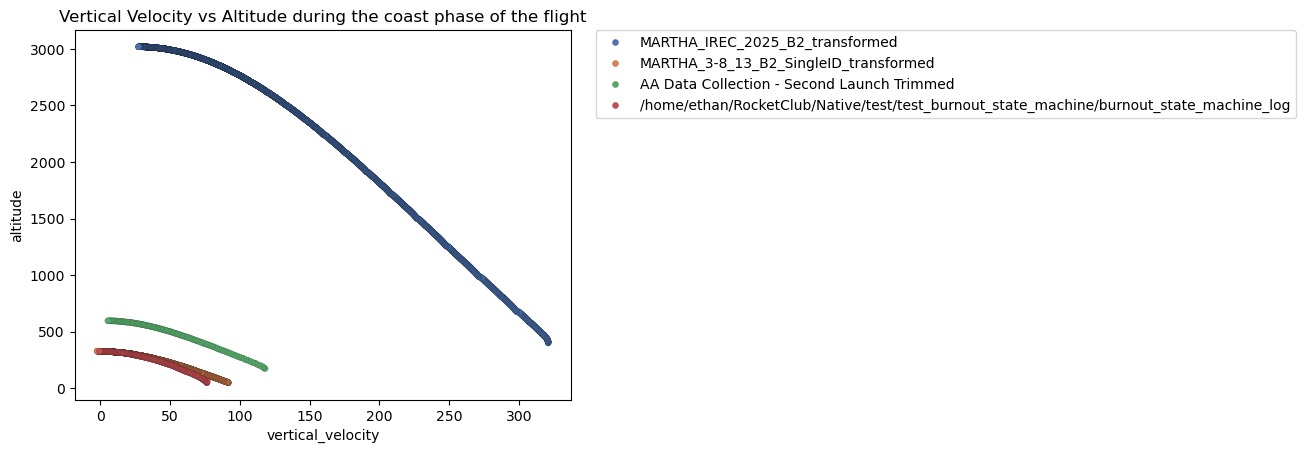

In [332]:
import seaborn as sns 

vv_alt_df = pd.read_csv("apogee_training_data.csv")  # replace with actual path

# Plot vertical velocity on the x axis and altitude on the y axis use flight_name as hue
sns.scatterplot(data=vv_alt_df, x="vertical_velocity", y="altitude", hue="flight_name", palette="deep", s=20, alpha=1, edgecolor='black', linewidth=0.1)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Vertical Velocity vs Altitude during the coast phase of the flight")
plt.show()



In [361]:
# Data generation from the training data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# Load the dataset
vv_alt_df = pd.read_csv("apogee_training_data.csv")

# Get all unique flights
flight_names = vv_alt_df["flight_name"].unique()
print(flight_names)

# Only keep the low-alt flights 
flight_names = [
 #    flight_names[0],
    flight_names[1],
    flight_names[2],
    flight_names[3]
]

# Train on just the second flight and third flights
vv_alt_df = vv_alt_df[vv_alt_df["flight_name"].isin(flight_names)]

print(vv_alt_df.head())


# # Add more rows by adding noise to existing data
# for row in vv_alt_df.itertuples():
#     for _ in range(10):
#         # Add noise to vertical velocity and vertical acceleration
#         noise_vv = np.random.normal(0, 0.2, 1)[0]  # Small noise for vertical velocity
#         noise_va = np.random.normal(0, 0.2, 1)[0]  # Small noise for vertical acceleration
#         new_row = {
#             "time": row.time,
#             "altitude": row.altitude + noise_vv * 10,  # Adjust altitude slightly
#             "vertical_velocity": row.vertical_velocity + noise_vv,
#             "vertical_acceleration": row.vertical_acceleration + noise_va,
#             "apogee": row.apogee,
#             "flight_name": row.flight_name
#         }
#         vv_alt_df = pd.concat([vv_alt_df, pd.DataFrame([new_row])], ignore_index=True)



['MARTHA_IREC_2025_B2_transformed' 'MARTHA_3-8_13_B2_SingleID_transformed'
 'AA Data Collection - Second Launch Trimmed'
 '/home/ethan/RocketClub/Native/test/test_burnout_state_machine/burnout_state_machine_log']
           time   altitude  vertical_velocity  vertical_acceleration  \
2054  1436761.0  47.725159          91.694752              -3.454662   
2055  1436771.0  48.990860          91.660205              -7.039111   
2056  1436781.0  48.990860          91.589814              -9.479790   
2057  1436791.0  48.990860          91.495016             -12.087967   
2058  1436801.0  50.369705          91.374137             -14.131437   

          apogee                            flight_name  
2054  326.640106  MARTHA_3-8_13_B2_SingleID_transformed  
2055  326.640106  MARTHA_3-8_13_B2_SingleID_transformed  
2056  326.640106  MARTHA_3-8_13_B2_SingleID_transformed  
2057  326.640106  MARTHA_3-8_13_B2_SingleID_transformed  
2058  326.640106  MARTHA_3-8_13_B2_SingleID_transformed  


In [362]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np



g = 9.80665
df = vv_alt_df.copy()

v = df["vertical_velocity"]
a = df["vertical_acceleration"]

vv_alt_df["delta_h_simple"]   = (v**2) / (2.0 * a.abs())
vv_alt_df["k_est"]            = np.maximum(0, -(a + g)) / (v**2 + 1e-4)
vv_alt_df["spec_energy"]      = 0.5 * v**2
vv_alt_df["a_norm_g"]         = a / g
vv_alt_df["jerk"]             = a.diff().fillna(0) / vv_alt_df["time"].diff().fillna(0.02)   # assuming 50 Hz
vv_alt_df["log_v"]            = np.log(np.abs(v) + 1e-2)
vv_alt_df["log_a"]            = np.log(np.abs(a) + 1e-3)

features = [
    "vertical_velocity",       
    "vertical_acceleration",   
    # "delta_h_simple",
    # "k_est",
    # "spec_energy",
]


# Features and target
X = vv_alt_df[features]
y = vv_alt_df["apogee"] - vv_alt_df["altitude"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Polynomial expansion
poly = PolynomialFeatures(degree=2, include_bias=True)  # include_bias=True gives the intercept term
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train polynomial regression model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
y_pred_poly = poly_reg.predict(X_test_poly)

# Evaluate
print("Polynomial Regression R²:", r2_score(y_test, y_pred_poly))
print("Polynomial Regression MAE:", mean_absolute_error(y_test, y_pred_poly))

# Print C++-compatible weights
feature_names = poly.get_feature_names_out(features)
print("\n// Polynomial Regression Coefficients for C++")
print("const float coeffs[] = {")
for name, coef in zip(feature_names, poly_reg.coef_):
    print(f"    /* {name} */ {coef:.8f},")
print("};")
print(f"const float intercept = {poly_reg.intercept_:.8f};")


Polynomial Regression R²: 0.9879544006437196
Polynomial Regression MAE: 5.261092709884139

// Polynomial Regression Coefficients for C++
const float coeffs[] = {
    /* 1 */ 0.00000000,
    /* vertical_velocity */ 3.28109767,
    /* vertical_acceleration */ -4.15661369,
    /* vertical_velocity^2 */ 0.02998674,
    /* vertical_velocity vertical_acceleration */ 0.29153575,
    /* vertical_acceleration^2 */ 0.89487385,
};
const float intercept = -150.74257259;


           time   altitude  vertical_velocity  vertical_acceleration  \
2054  1436761.0  47.725159          91.694752              -3.454662   
2055  1436771.0  48.990860          91.660205              -7.039111   
2056  1436781.0  48.990860          91.589814              -9.479790   
2057  1436791.0  48.990860          91.495016             -12.087967   
2058  1436801.0  50.369705          91.374137             -14.131437   

          apogee                            flight_name  delta_h_simple  \
2054  326.640106  MARTHA_3-8_13_B2_SingleID_transformed     1216.895691   
2055  326.640106  MARTHA_3-8_13_B2_SingleID_transformed      596.779389   
2056  326.640106  MARTHA_3-8_13_B2_SingleID_transformed      442.451449   
2057  326.640106  MARTHA_3-8_13_B2_SingleID_transformed      346.267402   
2058  326.640106  MARTHA_3-8_13_B2_SingleID_transformed      295.413433   

         k_est  spec_energy  a_norm_g      jerk     log_v     log_a  \
2054  0.000000  4203.963765 -0.352278  0.0000

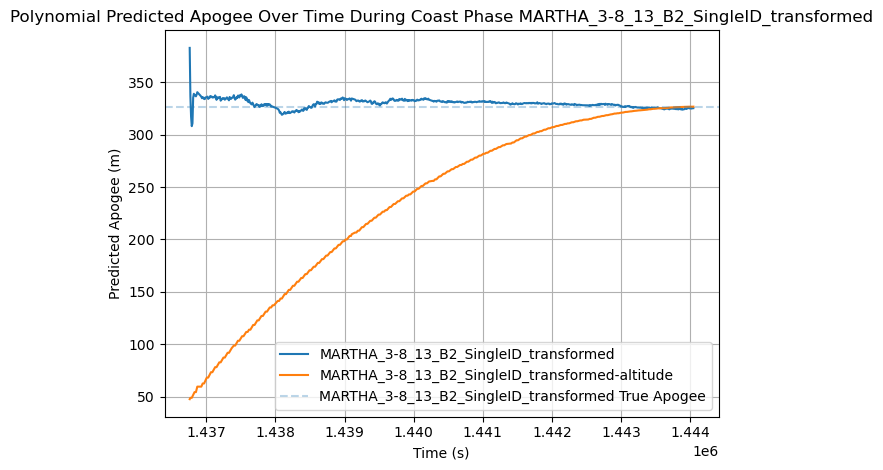

              time  altitude  vertical_velocity  vertical_acceleration  \
2756  3.677558e+06  173.2357         118.004426              -11.14998   
2757  3.677644e+06  182.9117         117.051329              -14.10272   
2758  3.677725e+06  192.3447         115.910389              -19.17550   
2759  3.677805e+06  201.0177         114.361977              -20.19480   
2760  3.677891e+06  208.9197         112.635115              -20.33840   

        apogee                                 flight_name  delta_h_simple  \
2756  598.1847  AA Data Collection - Second Launch Trimmed      624.442582   
2757  598.1847  AA Data Collection - Second Launch Trimmed      485.757840   
2758  598.1847  AA Data Collection - Second Launch Trimmed      350.322503   
2759  598.1847  AA Data Collection - Second Launch Trimmed      323.812609   
2760  598.1847  AA Data Collection - Second Launch Trimmed      311.889555   

         k_est  spec_energy  a_norm_g          jerk     log_v     log_a  \
2756  0.000

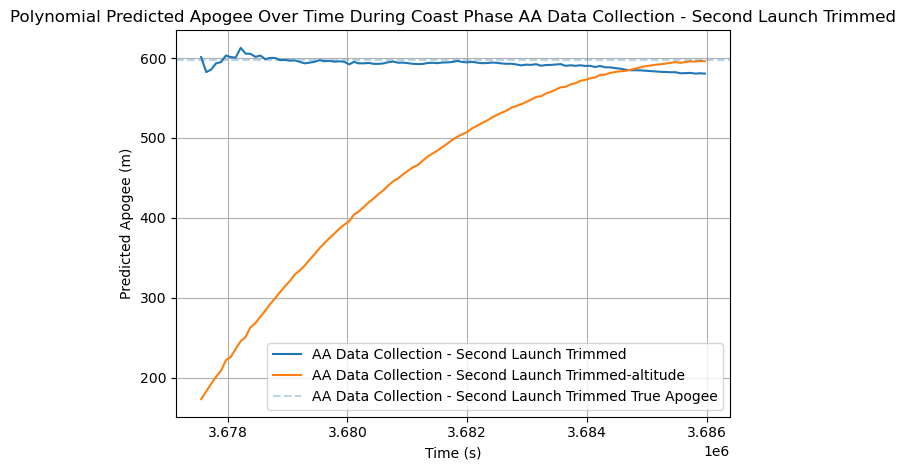

           time  altitude  vertical_velocity  vertical_acceleration   apogee  \
2859  1436761.0    48.053             76.394                 -3.455  326.959   
2860  1436801.0    50.697             76.144                -14.131  326.959   
2861  1436841.0    54.762             76.064                -18.065  326.959   
2862  1436881.0    59.993             76.626                -18.021  326.959   
2863  1436921.0    59.993             75.850                -17.973  326.959   

                                            flight_name  delta_h_simple  \
2859  /home/ethan/RocketClub/Native/test/test_burnou...      844.579340   
2860  /home/ethan/RocketClub/Native/test/test_burnou...      205.148565   
2861  /home/ethan/RocketClub/Native/test/test_burnou...      160.136510   
2862  /home/ethan/RocketClub/Native/test/test_burnou...      162.908381   
2863  /home/ethan/RocketClub/Native/test/test_burnou...      160.051814   

         k_est  spec_energy  a_norm_g      jerk     log_v     log_a 

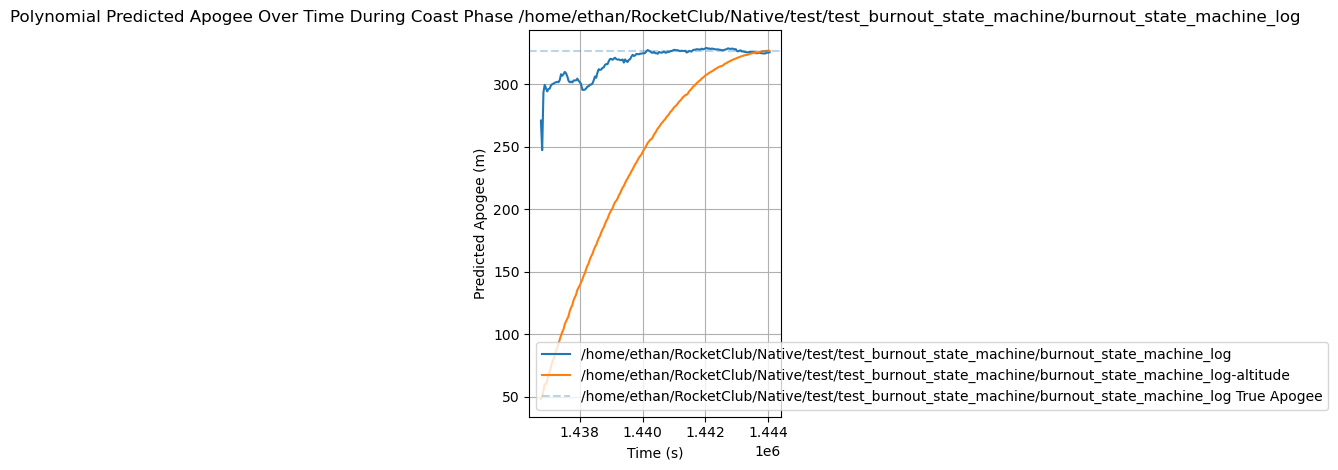

In [363]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Load full dataset
df = vv_alt_df.copy()

flight_names_again = df["flight_name"].unique()

for flight in flight_names_again:
    flight_df = df[df["flight_name"] == flight].copy()
    flight_df.sort_values("time", inplace=True)

    # Predict apogee at each time step
    X_flight = flight_df[features]
    X_flight_poly = poly.transform(X_flight)
    predicted_apogee_remaining = poly_reg.predict(X_flight_poly) 
    predicted_apogee = predicted_apogee_remaining + flight_df["altitude"]

    # Plot
    plt.plot(flight_df["time"], predicted_apogee, label=f"{flight}")
    plt.plot(flight_df["time"], flight_df["altitude"], label=f"{flight}-altitude")
    true_apogee = flight_df["apogee"].iloc[0]
    plt.axhline(true_apogee, linestyle="--", alpha=0.3, label=f"{flight} True Apogee")

    flight_df["predicted_apogee"] = predicted_apogee
    flight_df["predicted_apogee_remaining"] = predicted_apogee_remaining
    print(flight_df.head())

    plt.xlabel("Time (s)")
    plt.ylabel("Predicted Apogee (m)")
    plt.title(f"Polynomial Predicted Apogee Over Time During Coast Phase {flight}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


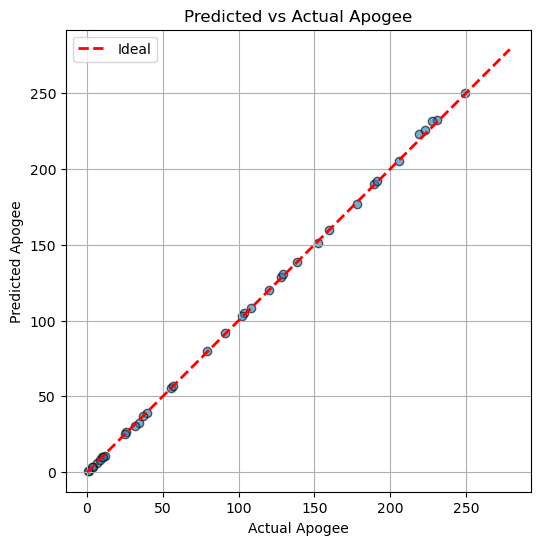

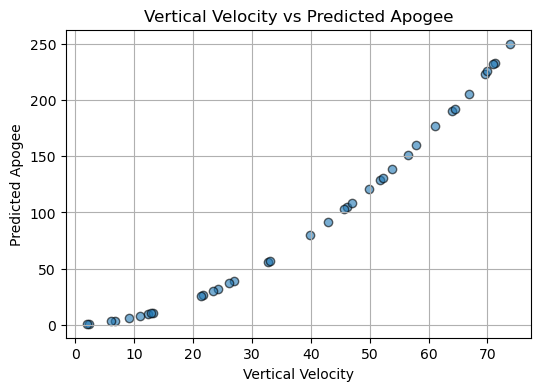

In [336]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal')
plt.xlabel("Actual Apogee")
plt.ylabel("Predicted Apogee")
plt.title("Predicted vs Actual Apogee")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

import matplotlib.pyplot as plt

# Use the test set's vertical velocity and predicted apogees
vertical_velocity_test = X_test["vertical_velocity"]

plt.figure(figsize=(6, 4))
plt.scatter(vertical_velocity_test, y_pred_poly, alpha=0.6, edgecolor='k')
plt.xlabel("Vertical Velocity")
plt.ylabel("Predicted Apogee")
plt.title("Vertical Velocity vs Predicted Apogee")
plt.grid(True)
plt.show()



In [337]:
vv_alt_df = pd.read_csv("apogee_training_data.csv")  # replace with actual path
print(vv_alt_df.head())

         time    altitude  vertical_velocity  vertical_acceleration  \
0  31340722.0  399.521545         321.123772              -0.544990   
1  31340732.0  404.125366         321.118322              -2.200824   
2  31340742.0  408.482117         321.096314              -3.244095   
3  31340752.0  412.838867         321.063873              -4.153368   
4  31340762.0  412.838867         321.022339              -4.942998   

        apogee                      flight_name  
0  3018.870239  MARTHA_IREC_2025_B2_transformed  
1  3018.870239  MARTHA_IREC_2025_B2_transformed  
2  3018.870239  MARTHA_IREC_2025_B2_transformed  
3  3018.870239  MARTHA_IREC_2025_B2_transformed  
4  3018.870239  MARTHA_IREC_2025_B2_transformed  


In [338]:
# !pip install -U scikit-learn
# !pip install -U seaborn
# !pip install -U plotly

In [339]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

# Load the dataset
vv_alt_df = pd.read_csv("apogee_training_data.csv")

# Features and target
X = vv_alt_df[["altitude", "vertical_velocity", "vertical_acceleration"]]
y = vv_alt_df["apogee"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train baseline model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Train a nonlinear model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))


Linear Regression R²: 0.9908357502275227
Linear Regression MAE: 97.03230380232021
Random Forest R²: 0.9976886810437463
Random Forest MAE: 3.1258950820248566


<Axes: xlabel='vertical_velocity', ylabel='apogee'>

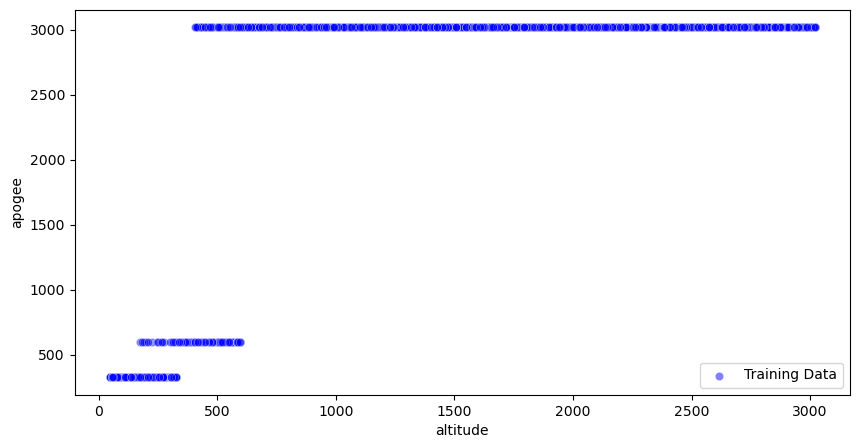

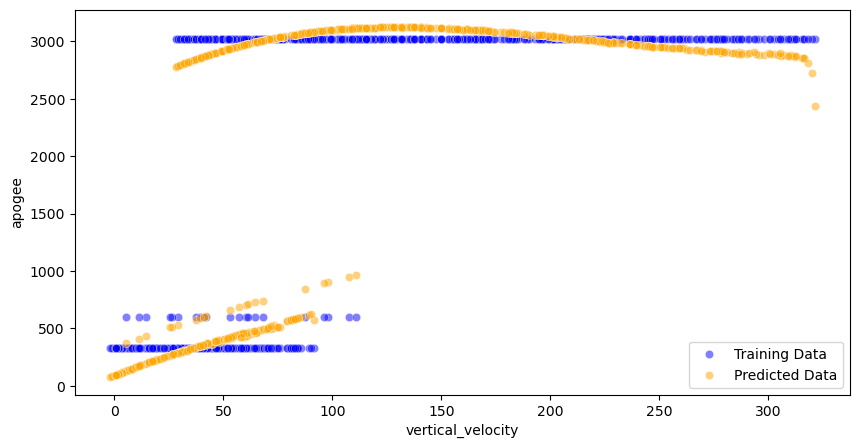

In [340]:
import matplotlib.pyplot as plt

# Plot altitude vs predicted apogee for lr
plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_train["altitude"], y=y_train, label="Training Data", color='blue', alpha=0.5)

plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_test["vertical_velocity"], y=y_test, label="Training Data", color='blue', alpha=0.5)
sns.scatterplot(x=X_test["vertical_velocity"], y=y_pred_lr, label="Predicted Data", color='orange', alpha=0.5)


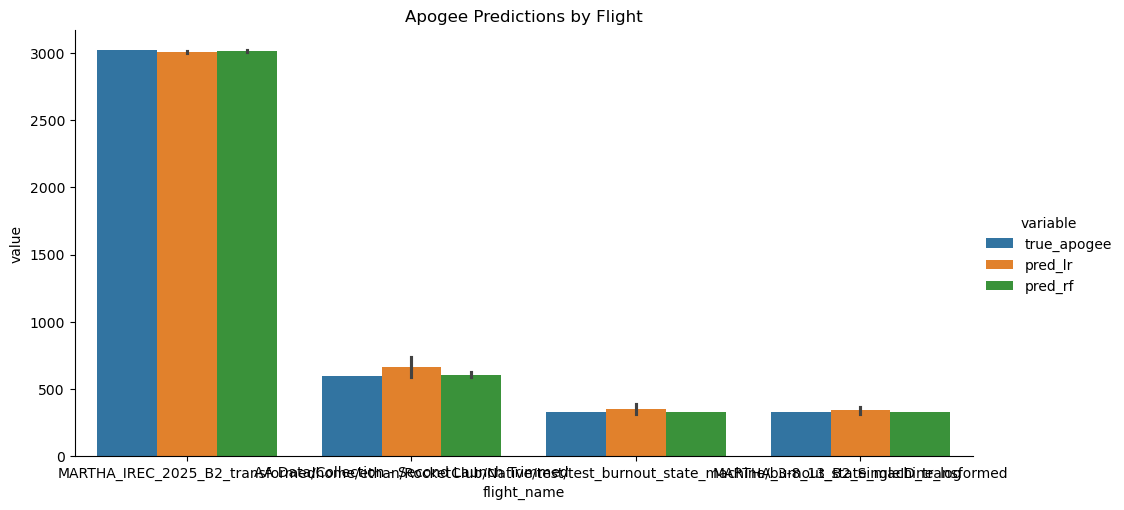

In [341]:
# Add back flight names to test set
X_test_with_meta = X_test.copy()
X_test_with_meta["true_apogee"] = y_test
X_test_with_meta["pred_lr"] = y_pred_lr
X_test_with_meta["pred_rf"] = y_pred_rf
X_test_with_meta["flight_name"] = vv_alt_df.loc[y_test.index, "flight_name"]

sns.catplot(
    data=X_test_with_meta.melt(id_vars=["flight_name"], value_vars=["true_apogee", "pred_lr", "pred_rf"]),
    kind="bar",
    x="flight_name",
    y="value",
    hue="variable",
    height=5,
    aspect=2
).set(title="Apogee Predictions by Flight")


In [342]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load data
vv_alt_df = pd.read_csv("apogee_training_data.csv")

# Prepare data
X = vv_alt_df[["altitude", "vertical_velocity", "vertical_acceleration"]]
y = vv_alt_df["apogee"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

# rf model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Compare accuracy
lr_accuracy = lr.score(X_test, y_test)
rf_accuracy = rf.score(X_test, y_test)

print(f"Linear Regression Accuracy: {lr_accuracy:.2f}")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")




Linear Regression Accuracy: 0.99
Random Forest Accuracy: 1.00


In [343]:

# Fix vertical acceleration at a representative value (e.g. 0 or mean)
fixed_va = X["vertical_acceleration"].mean()

# Create grid for surface
alt_range = np.linspace(X["altitude"].min(), X["altitude"].max(), 50)
vv_range = np.linspace(X["vertical_velocity"].min(), X["vertical_velocity"].max(), 50)
ALT, VV = np.meshgrid(alt_range, vv_range)

# Flatten and build DataFrame with fixed vertical_acceleration
X_grid = pd.DataFrame({
    "altitude": ALT.ravel(),
    "vertical_velocity": VV.ravel(),
    "vertical_acceleration": fixed_va  # constant
})
Z_pred = rf.predict(X_grid).reshape(ALT.shape)

# Plotly 3D Scatter + Surface
fig = go.Figure()

# True test data
fig.add_trace(go.Scatter3d(
    x=X_test["altitude"],
    y=X_test["vertical_velocity"],
    z=y_test,
    mode='markers',
    marker=dict(size=4, color='blue'),
    name="True Apogee"
))

# Predicted surface (slice at fixed acceleration)
fig.add_trace(go.Surface(
    x=alt_range,
    y=vv_range,
    z=Z_pred,
    colorscale='YlOrRd',
    opacity=0.7,
    name=f"Predicted Surface (VA={fixed_va:.2f})"
))

fig.update_layout(
    title="Apogee Prediction Surface Slice (Fixed Vertical Acceleration)",
    scene=dict(
        xaxis_title='Altitude (m)',
        yaxis_title='Vertical Velocity (m/s)',
        zaxis_title='Predicted Apogee (m)'
    ),
    width=900,
    height=700
)

fig.show()
